# Self-Correction Evaluation

In this notebook, we analyze the results of all dataset–model pairs from the self-refinement evaluation experiment. The analysis focuses on model performance before and after hint injection, the role of the `max_tokens` parameter used during generation, and comparisons among model families.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plots import plot_by_dataset, plot_aggregated_metric_by_dataset, plot_model_category_comparison, plot_metric_heatmap, plot_accuracy_vs_correction_scatter, plot_tokens_boxplot, plot_four_category_boxplot, plot_token_stage_boxplot

In [2]:
# Load data
metrics = pd.read_csv("outputs/metrics.csv")
per_question_tokens = pd.read_csv("outputs/per_question_tokens.csv")

In [3]:
MODELS_NON_REASONING=[
  "google/gemma-2-2b-it",
  "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "microsoft/Phi-4-mini-instruct",
  "Qwen/Qwen2.5-Math-1.5B",
  "Qwen/Qwen2.5-Math-7B" # not sure keep or not
]

MODELS_REASONING=[
  "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
  "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B",
  "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
  "microsoft/Phi-4-mini-reasoning"
]

In [4]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


## I. Effect of Maximum Token Budget
This section analyzes how increasing the maximum number of tokens affects model performance across different datasets.

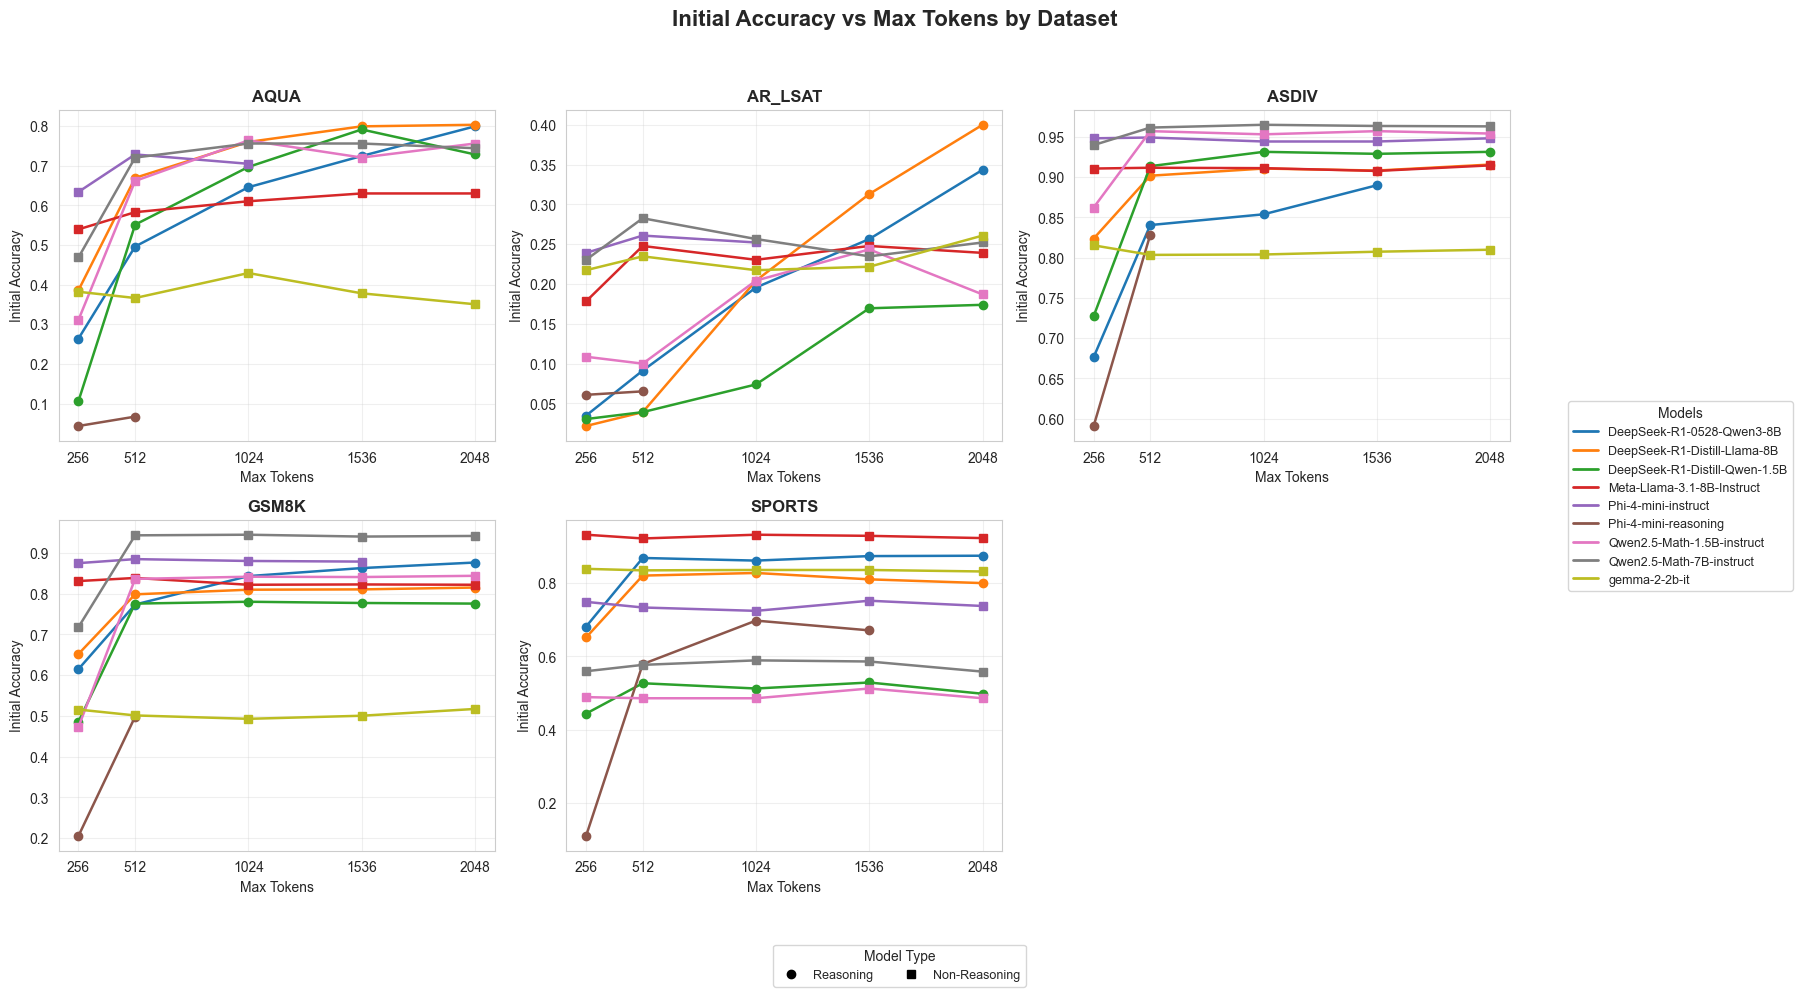

In [5]:
# Initial Accuracy
plot_by_dataset(
    metrics, "initial_accuracy", "Initial Accuracy",
    "Initial Accuracy vs Max Tokens by Dataset"
)

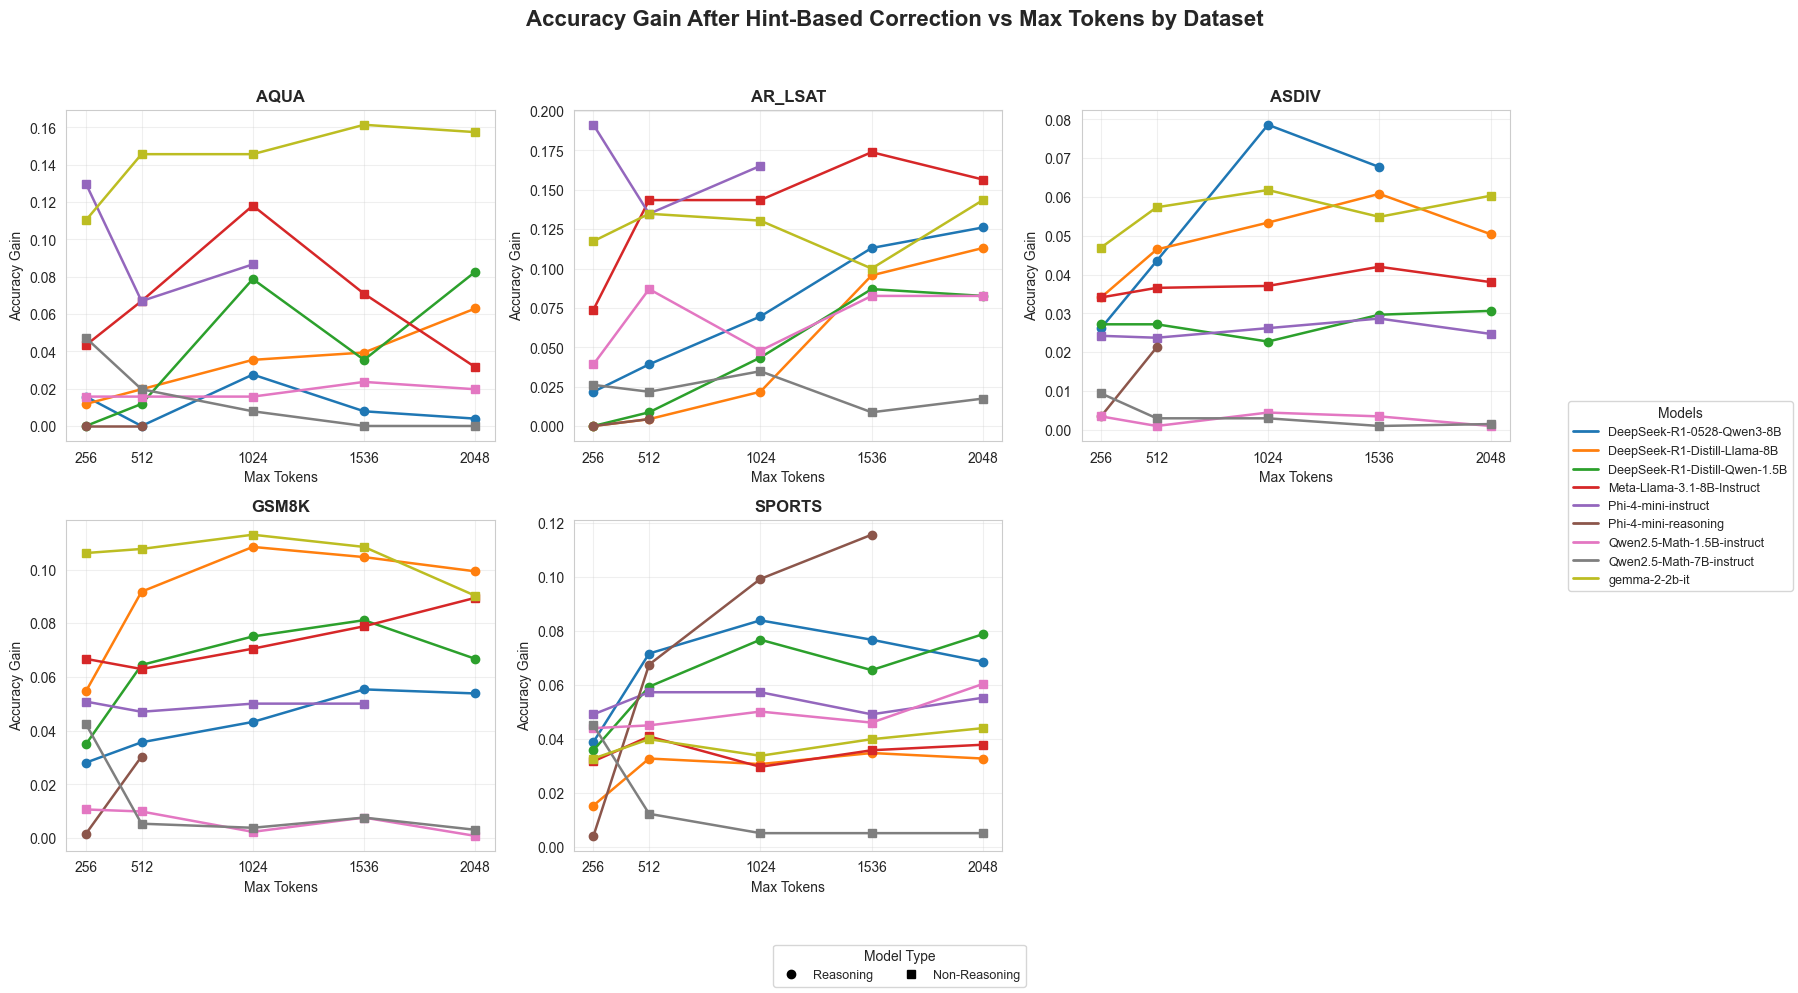

In [6]:
# Improvement in accuracy after applying hints (post-hint − initial)
plot_by_dataset(
    metrics, "delta_accuracy", "Accuracy Gain",
    "Accuracy Gain After Hint-Based Correction vs Max Tokens by Dataset"
)

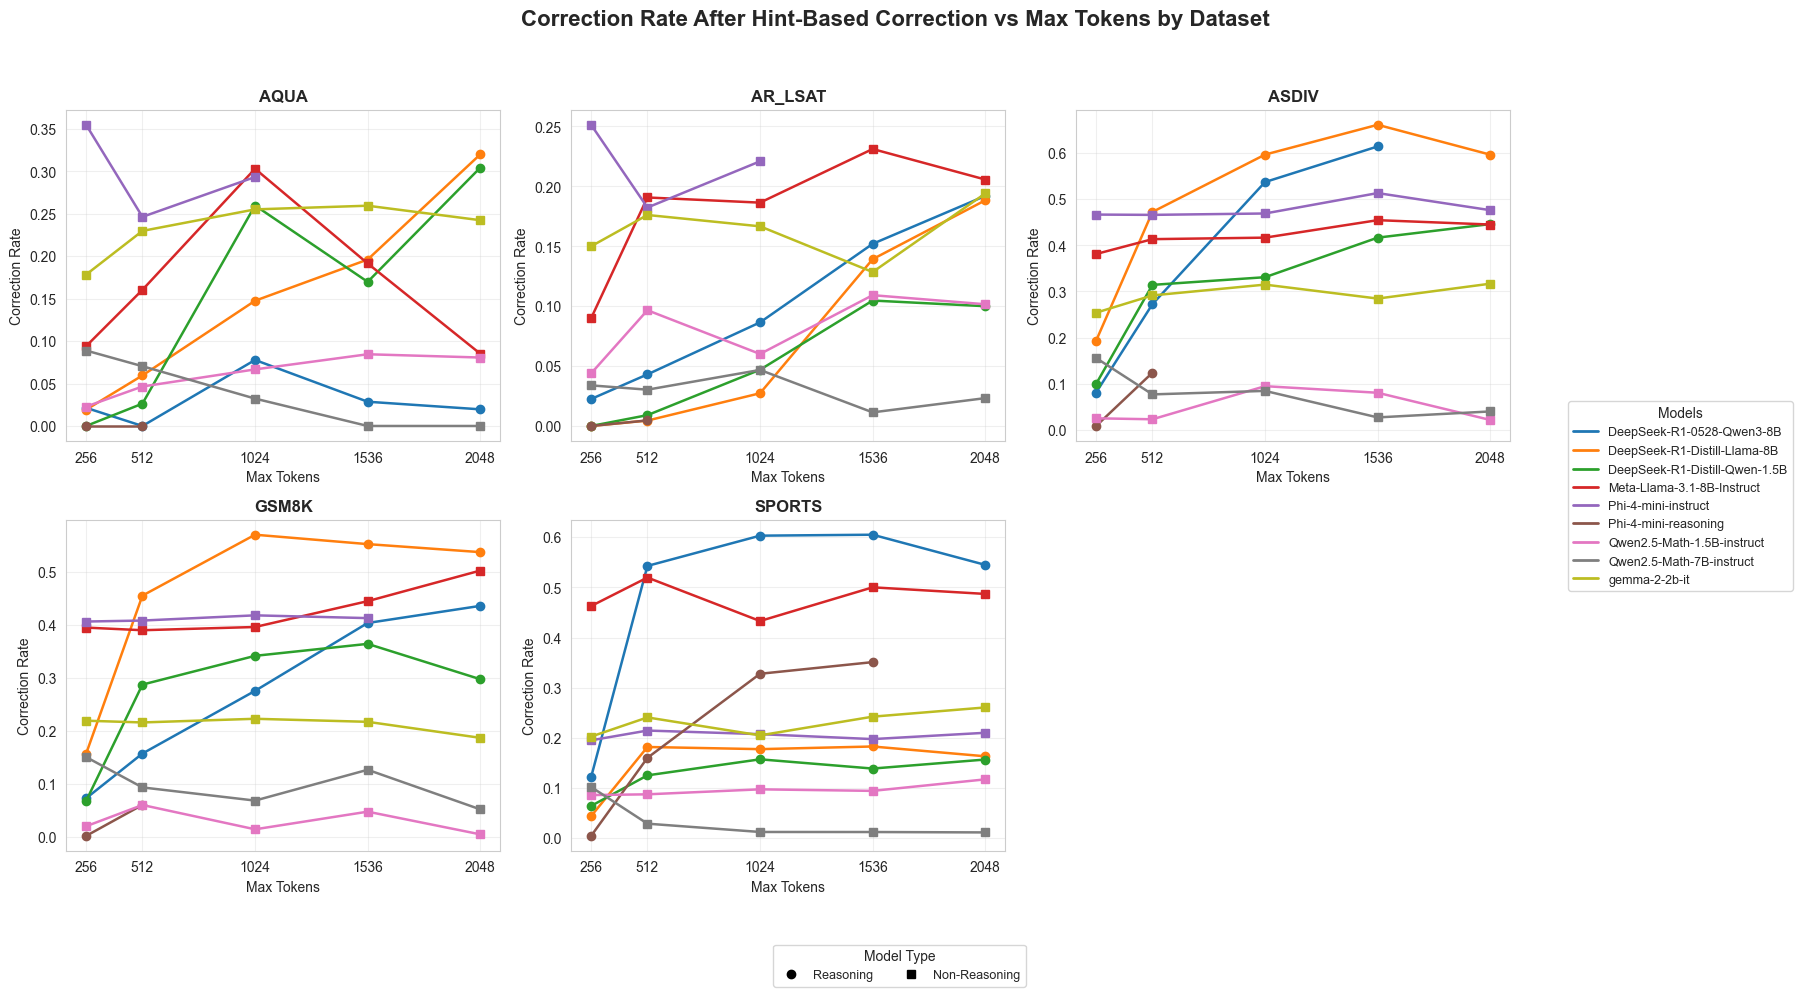

In [7]:
# Proportion of initially incorrect answers successfully corrected by hints
plot_by_dataset(
    metrics, "correction_rate", "Correction Rate",
    "Correction Rate After Hint-Based Correction vs Max Tokens by Dataset"
)

## II. Analysis of Aggregated Performance Metrics

In [8]:
aggregated_metrics = (
    metrics
    .groupby(['model', 'dataset', 'model_category'])
    .agg({
        'initial_accuracy': 'mean',
        'post_hint_accuracy': 'mean',
        'delta_accuracy': 'mean',
        'n_incorrect_initial': 'sum',
        'n_corrected': 'sum',
        'correction_rate': 'mean'
    })
    .reset_index()
)

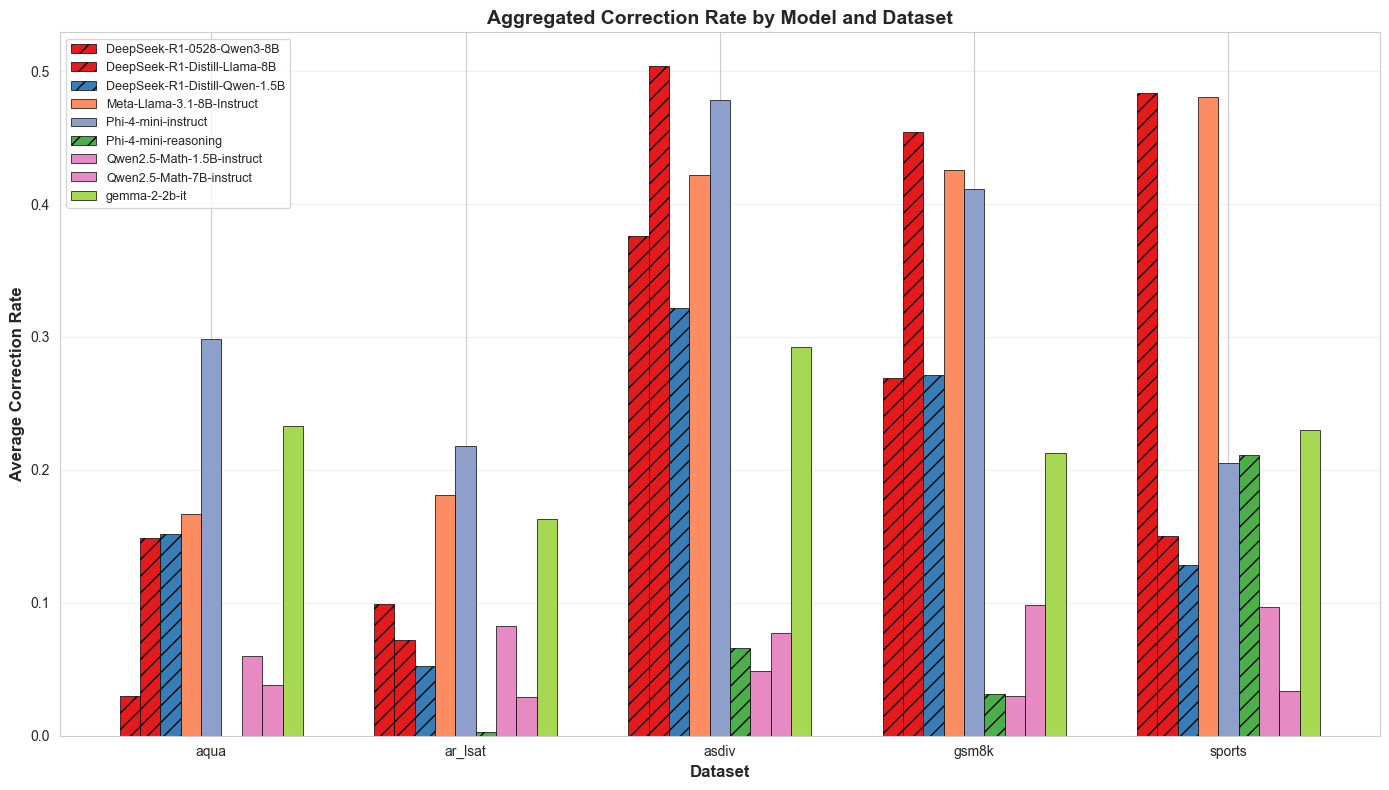

In [9]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='correction_rate',
    ylabel='Average Correction Rate',
    title='Aggregated Correction Rate by Model and Dataset'
)


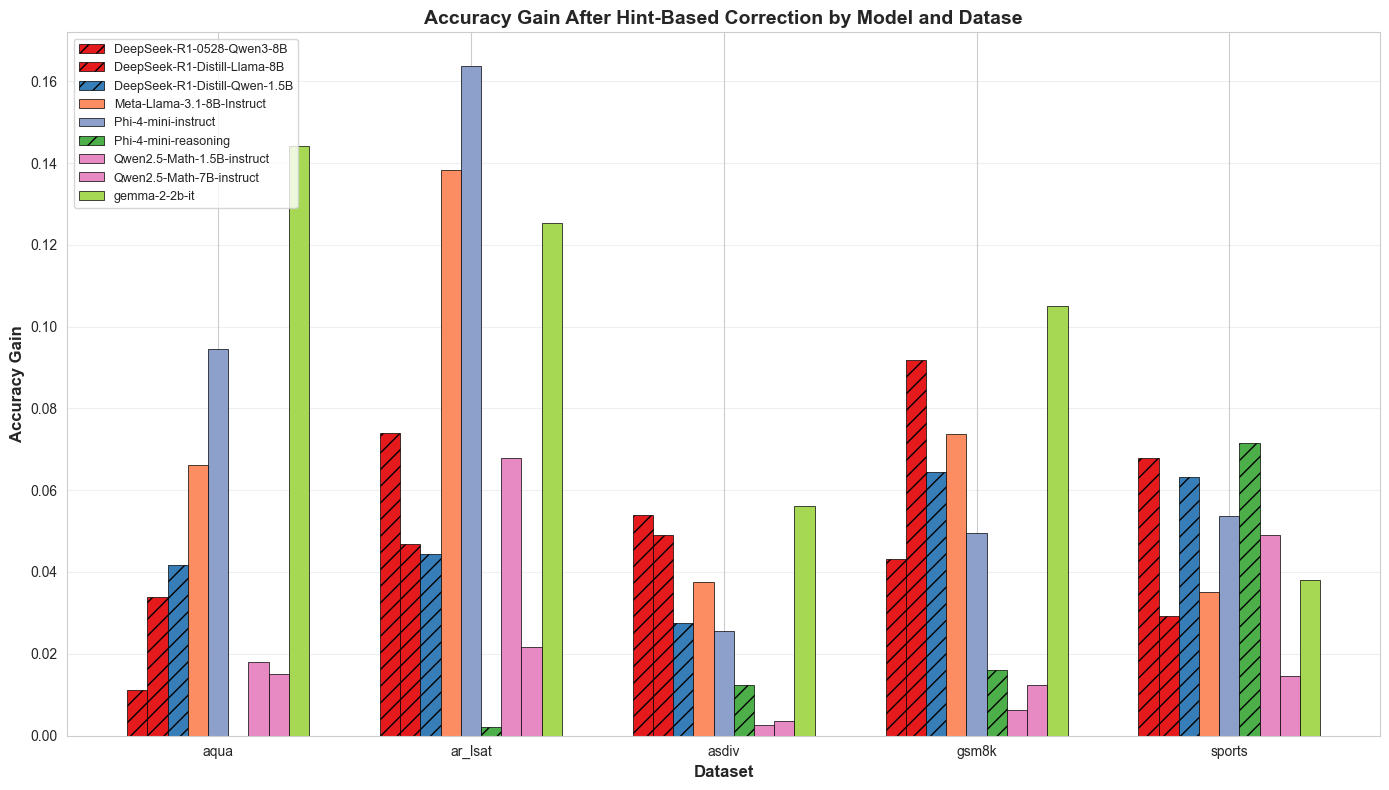

In [10]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='delta_accuracy',
    ylabel='Accuracy Gain',
    title=('Accuracy Gain After Hint-Based Correction by Model and Datase')
)


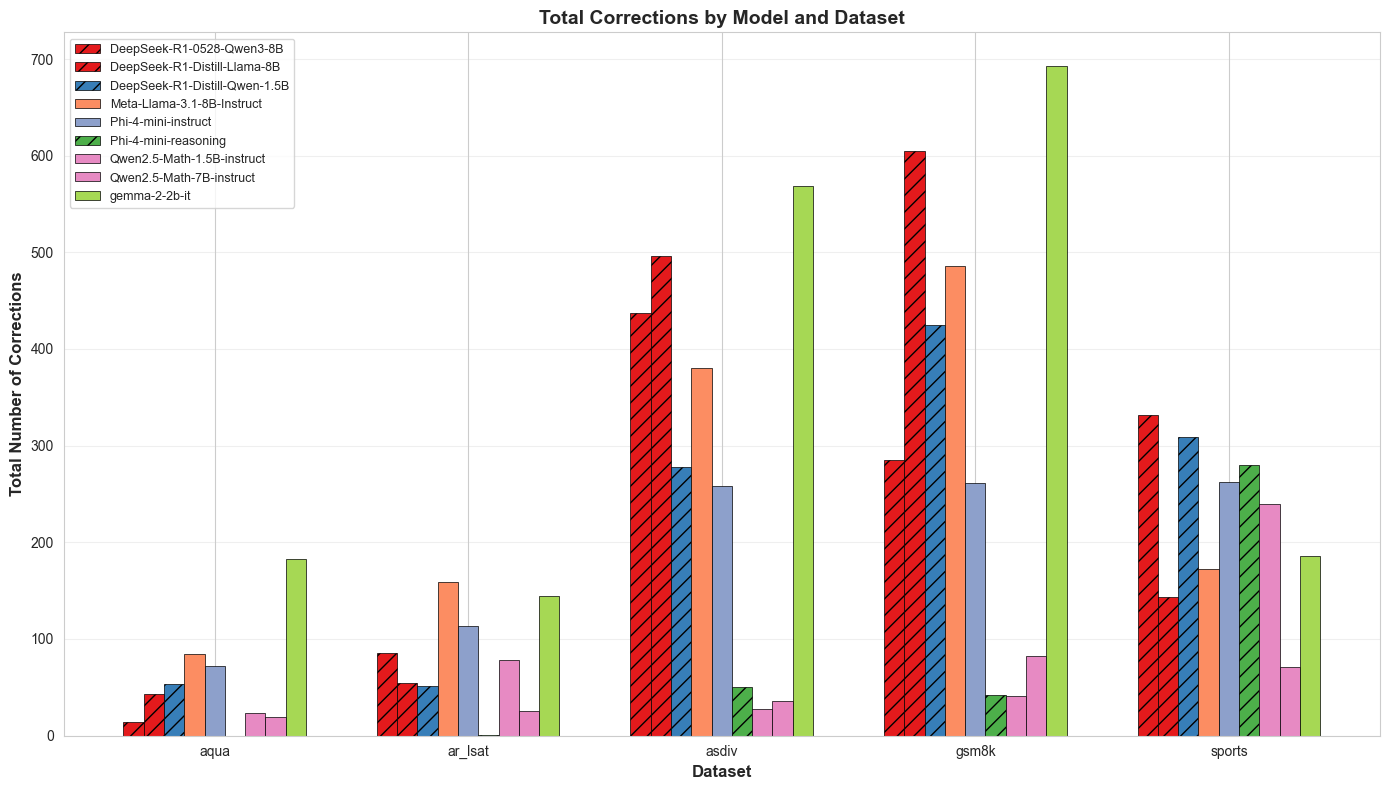

In [11]:
plot_aggregated_metric_by_dataset(
    aggregated_metrics,
    metric_col='n_corrected',
    ylabel='Total Number of Corrections',
    title='Total Corrections by Model and Dataset'
)


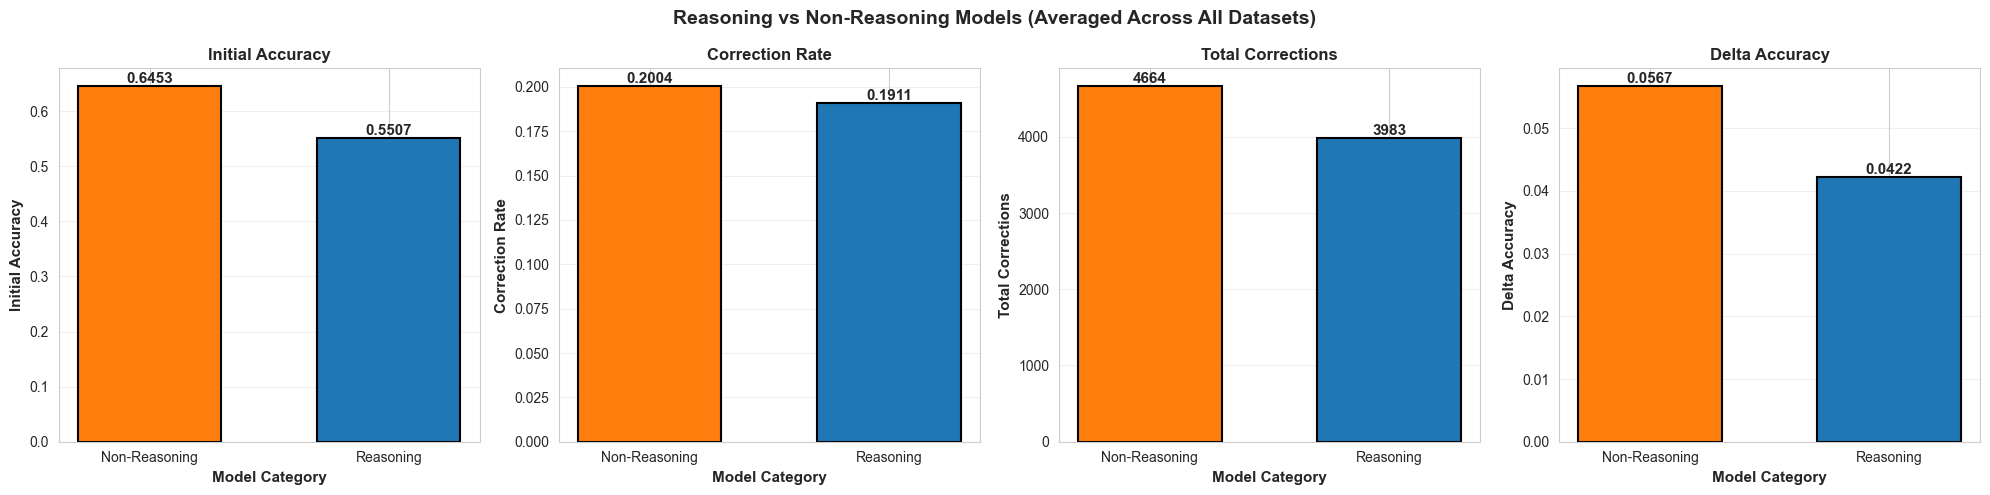

In [12]:
plot_model_category_comparison(aggregated_metrics)

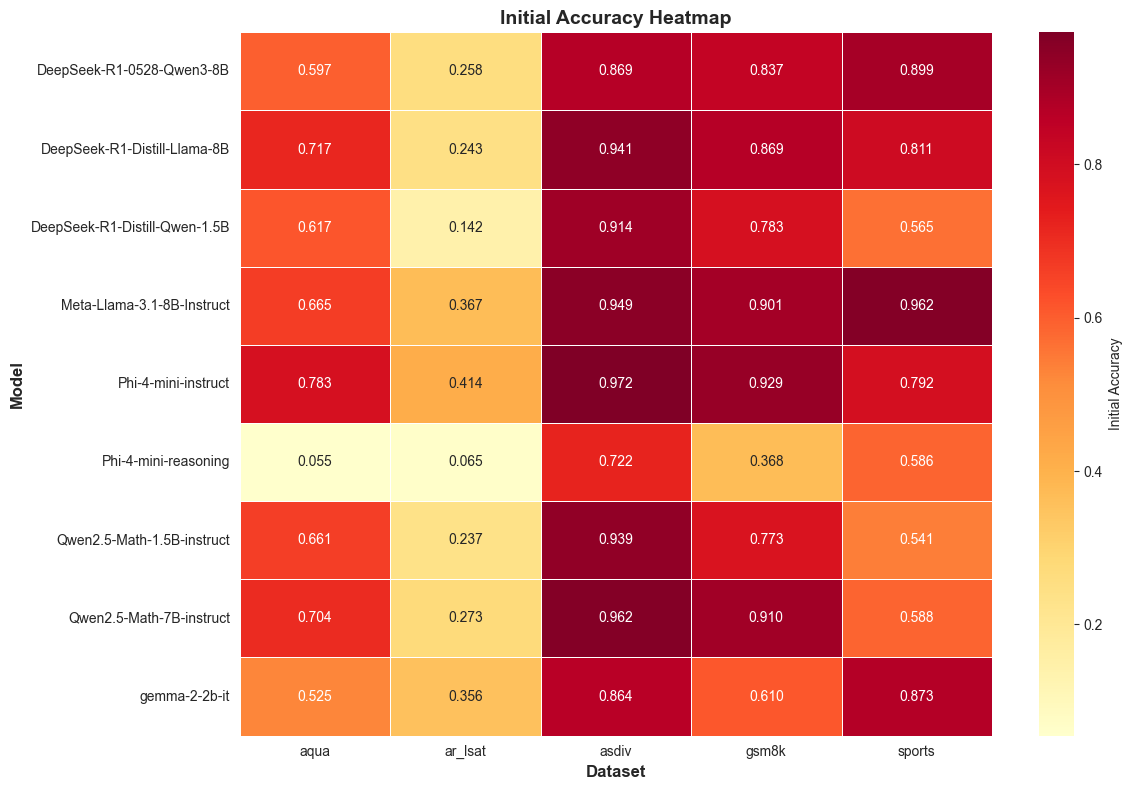

In [13]:
# 9. Initial Accuracy (your code used post_hint_accuracy; keep that exact behavior)
plot_metric_heatmap(
    aggregated_metrics,
    value_col="post_hint_accuracy",
    title="Initial Accuracy Heatmap",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Initial Accuracy"
)


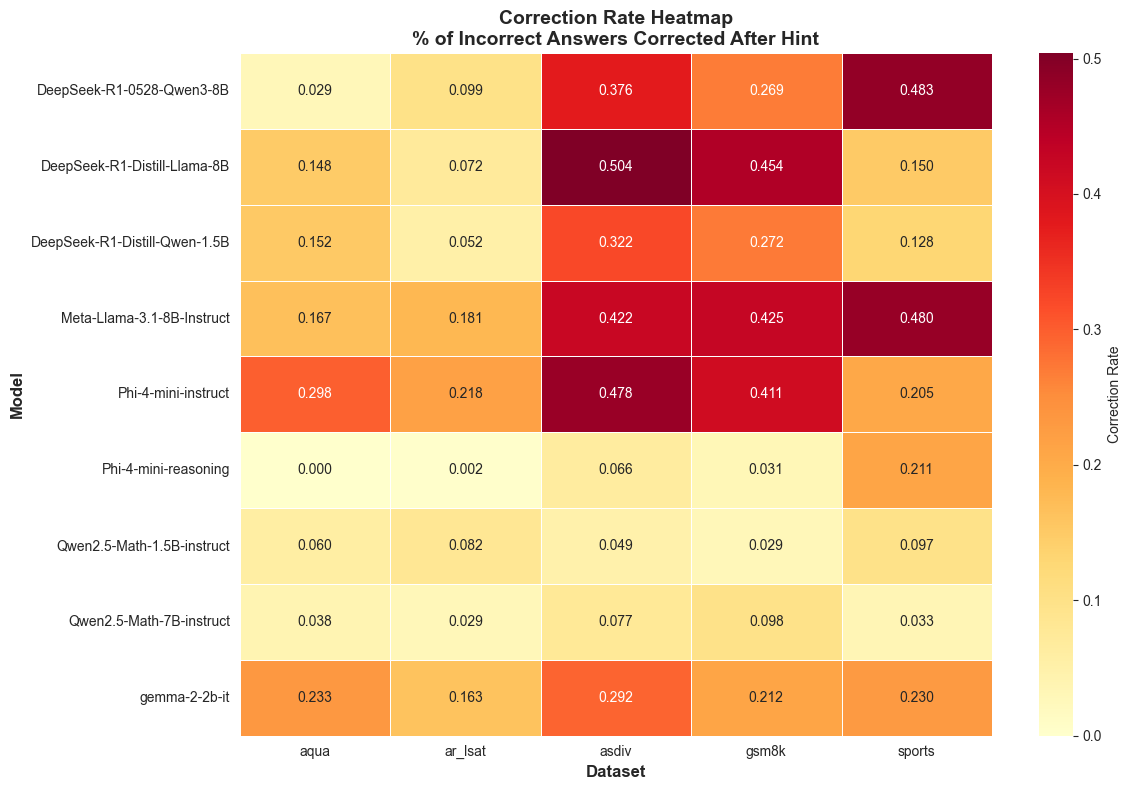

In [14]:
# 10. Correction Rate
plot_metric_heatmap(
    aggregated_metrics,
    value_col="correction_rate",
    title="Correction Rate Heatmap\n% of Incorrect Answers Corrected After Hint",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Correction Rate"
)

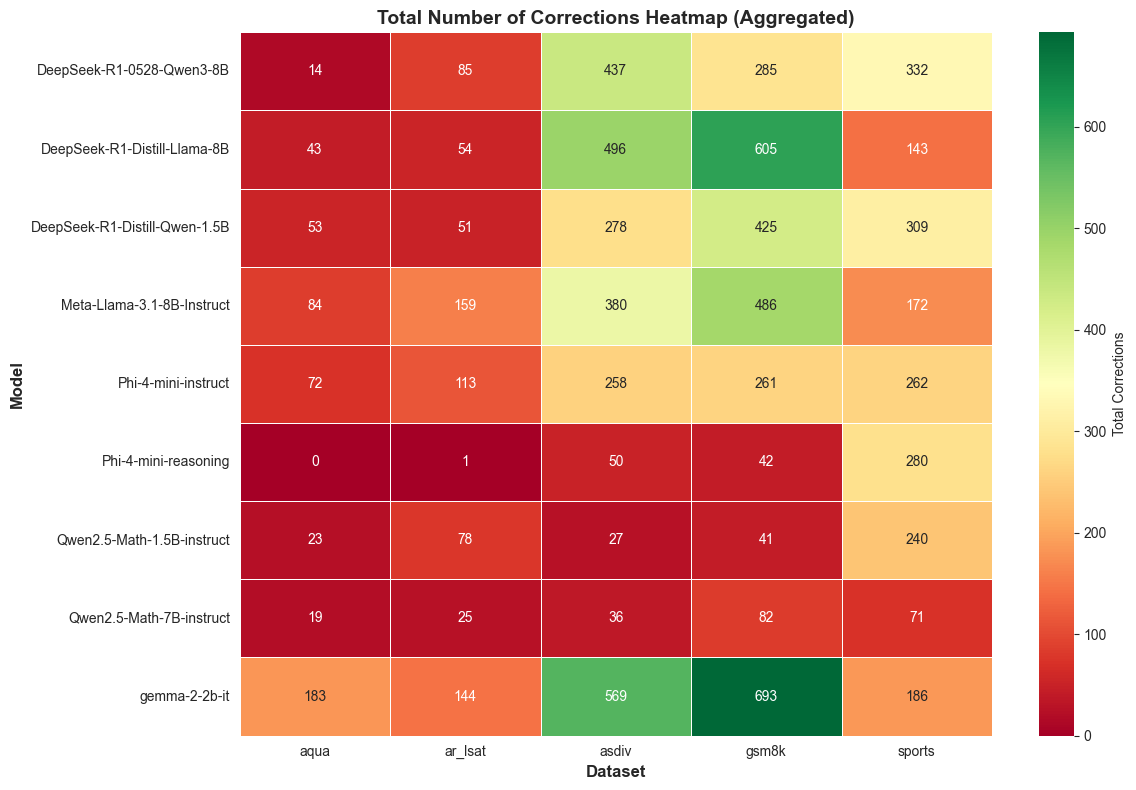

In [15]:
# 11. Total Corrections
plot_metric_heatmap(
    aggregated_metrics,
    value_col="n_corrected",
    title="Total Number of Corrections Heatmap (Aggregated)",
    cmap="RdYlGn",
    fmt=".0f",
    cbar_label="Total Corrections"
)

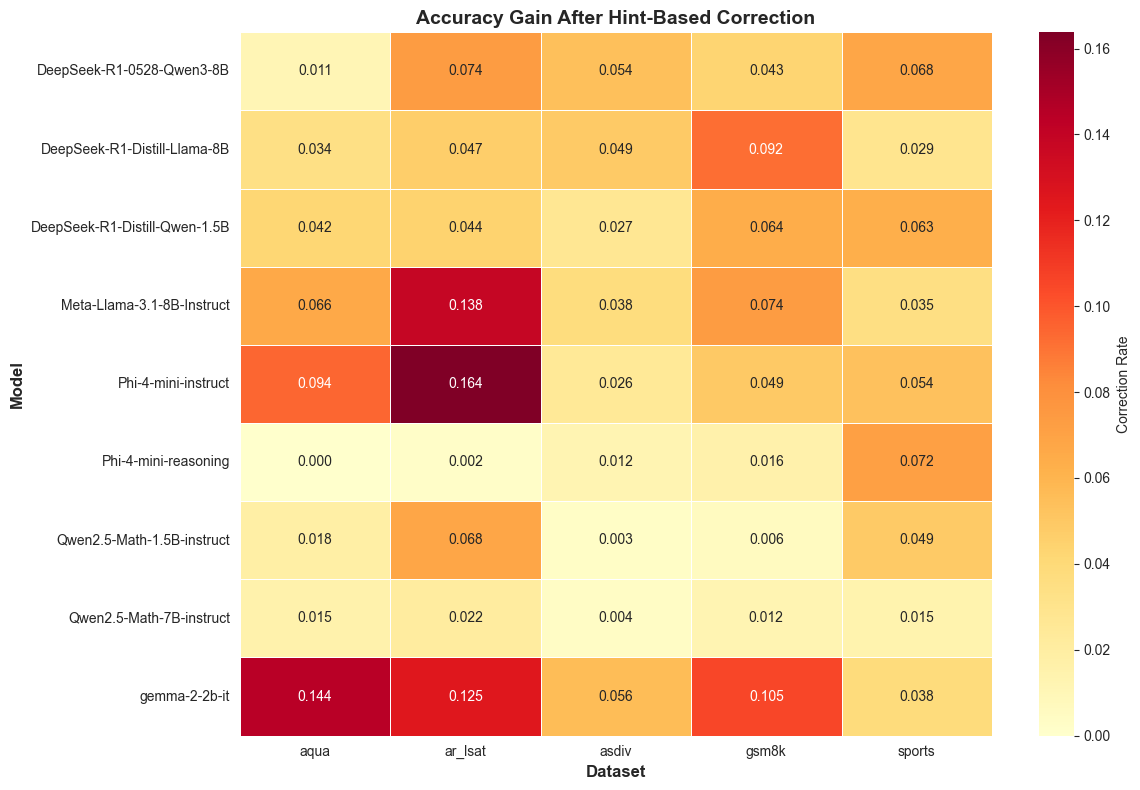

In [16]:
plot_metric_heatmap(
    aggregated_metrics,
    value_col="delta_accuracy",
    title="Accuracy Gain After Hint-Based Correction",
    cmap="YlOrRd",
    fmt=".3f",
    cbar_label="Correction Rate"
)

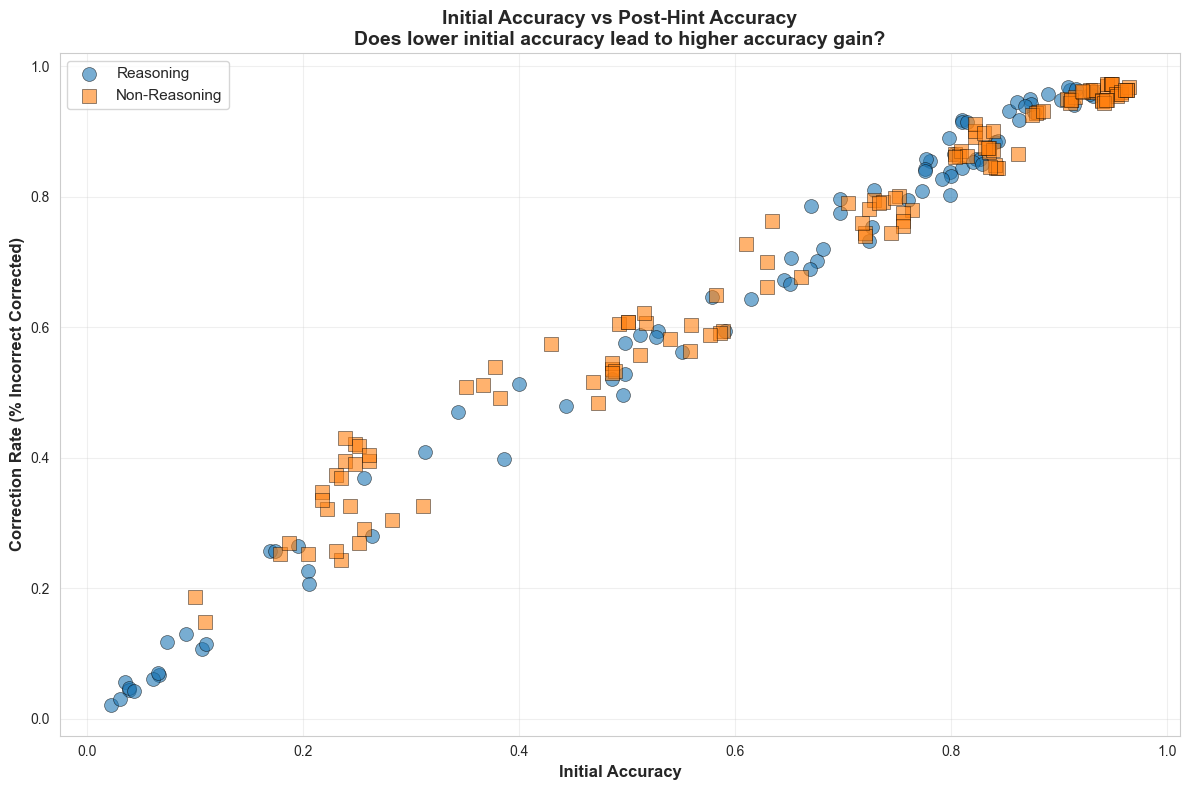

In [17]:
plot_accuracy_vs_correction_scatter(
    metrics,
    x_col="initial_accuracy",
    y_col="post_hint_accuracy",
    title="Initial Accuracy vs Post-Hint Accuracy\nDoes lower initial accuracy lead to higher accuracy gain?"
)


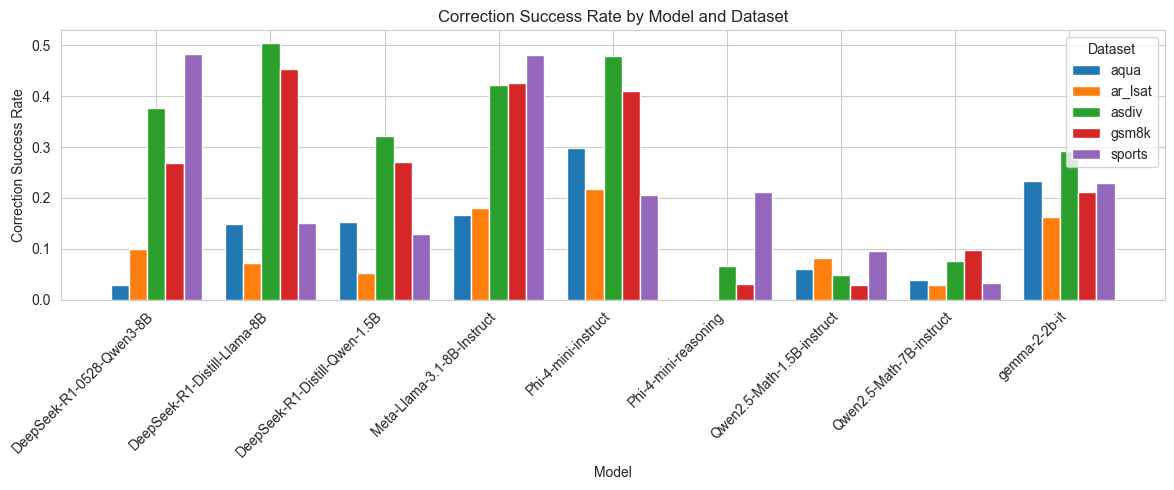

In [18]:
# Aggregate
grouped = (
    metrics
    .groupby(["model", "dataset"])["correction_rate"]
    .mean()
    .unstack()
)

models = grouped.index
datasets = grouped.columns

x = np.arange(len(models))
width = 0.8 / len(datasets)

plt.figure(figsize=(12, 5))

for i, dataset in enumerate(datasets):
    plt.bar(
        x + i * width,
        grouped[dataset],
        width,
        label=dataset
    )

plt.ylabel("Correction Success Rate")
plt.xlabel("Model")
plt.title("Correction Success Rate by Model and Dataset")
plt.xticks(x + width * (len(datasets) - 1) / 2, models, rotation=45, ha="right")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


### IV. Generated Tokens Number 

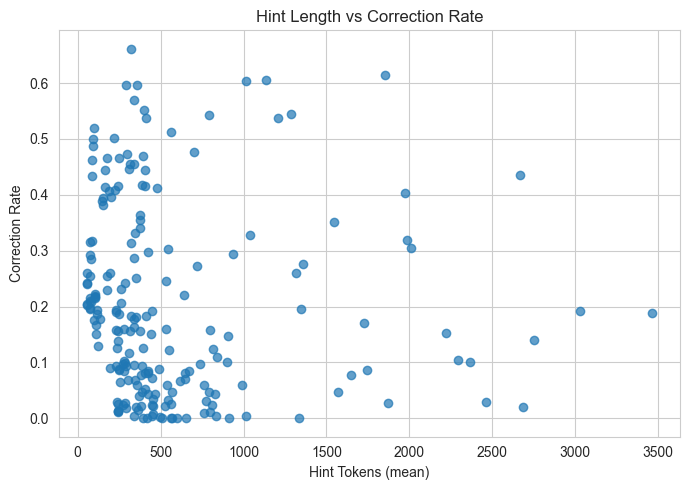

In [19]:
x = metrics["hint_tokens_mean"].values
y = metrics["correction_rate"].values

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Hint Tokens (mean)")
plt.ylabel("Correction Rate")
plt.title("Hint Length vs Correction Rate")
plt.tight_layout()
plt.show()


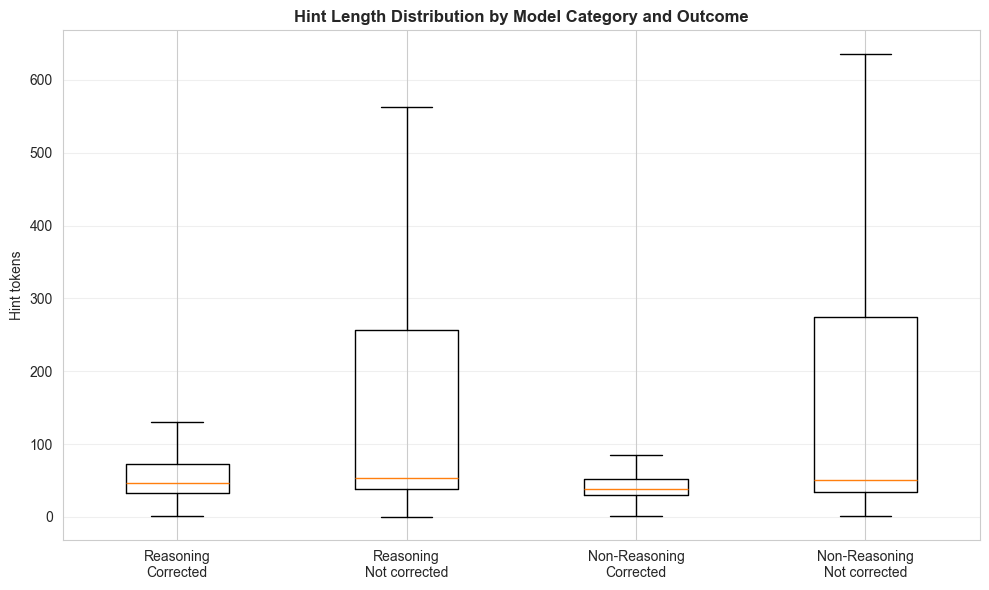

In [20]:
plot_four_category_boxplot(
    per_question_tokens,
    value_col="hint_tokens",
    title="Hint Length Distribution by Model Category and Outcome",
    ylabel="Hint tokens",
    show_fliers=False
)


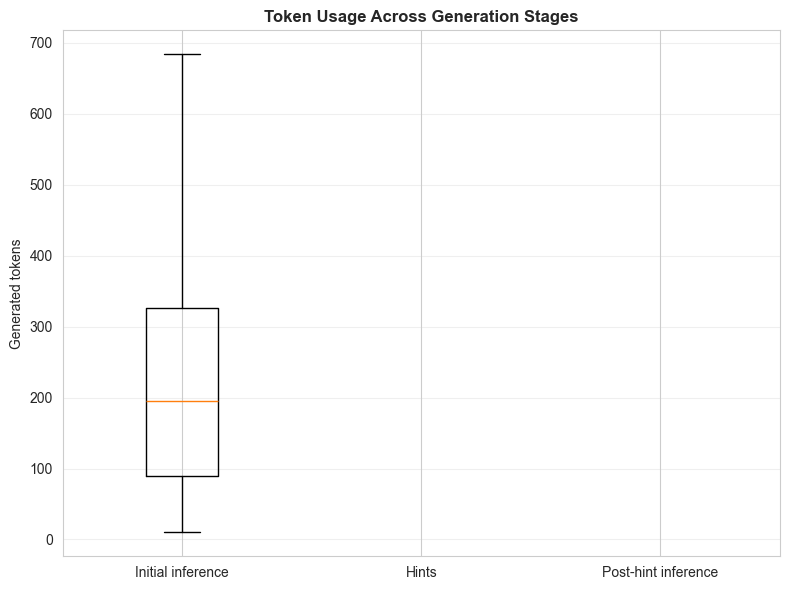

In [21]:
plot_token_stage_boxplot(per_question_tokens)


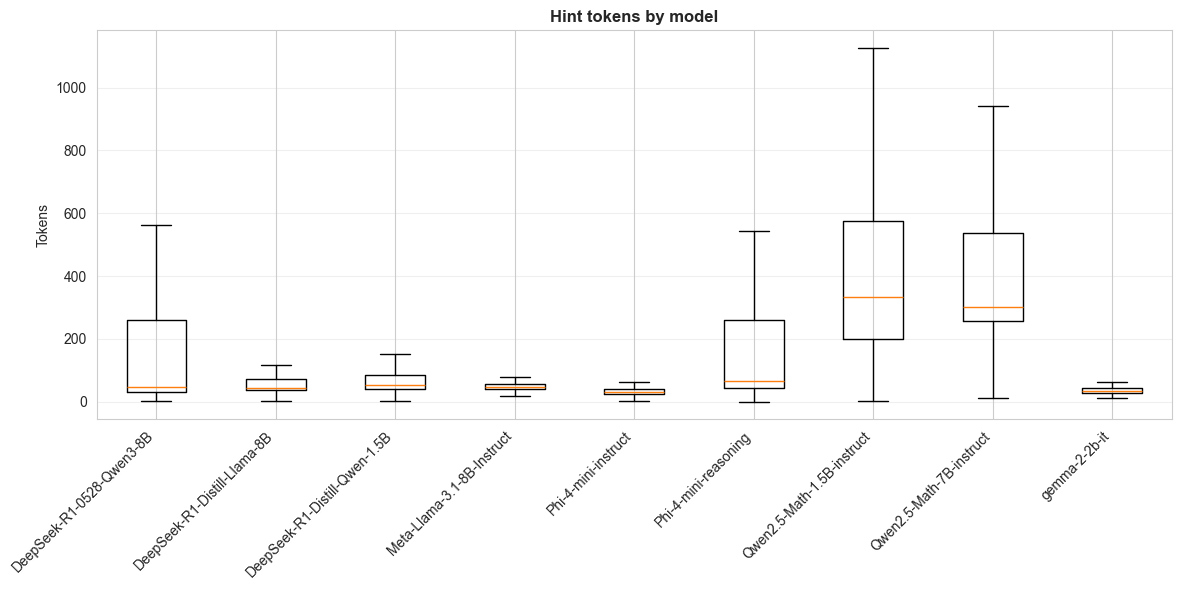

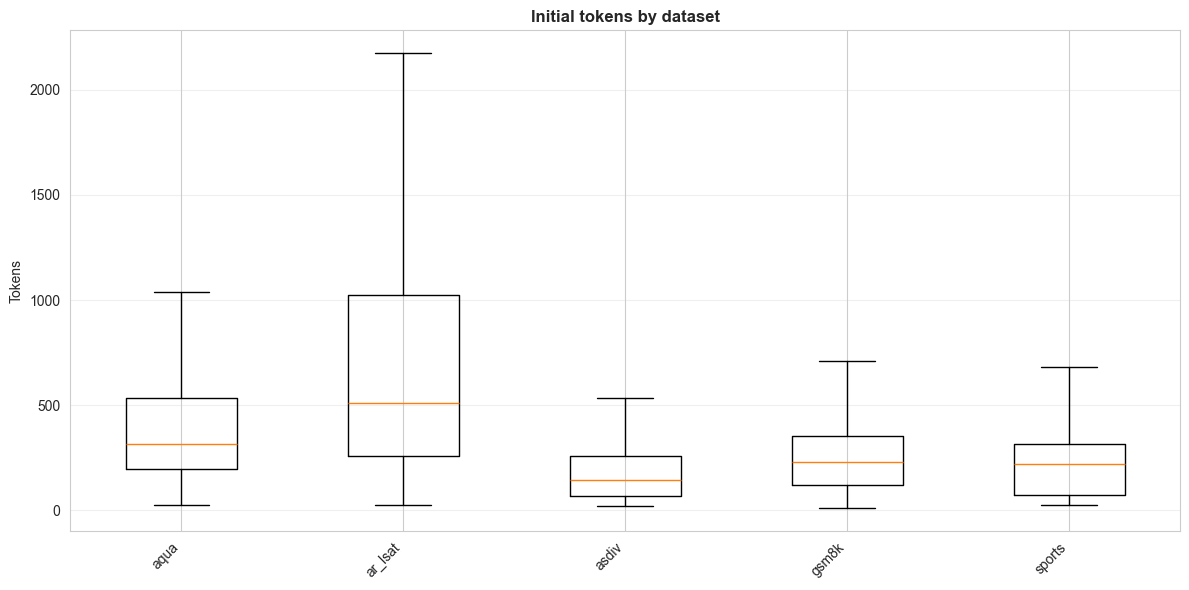

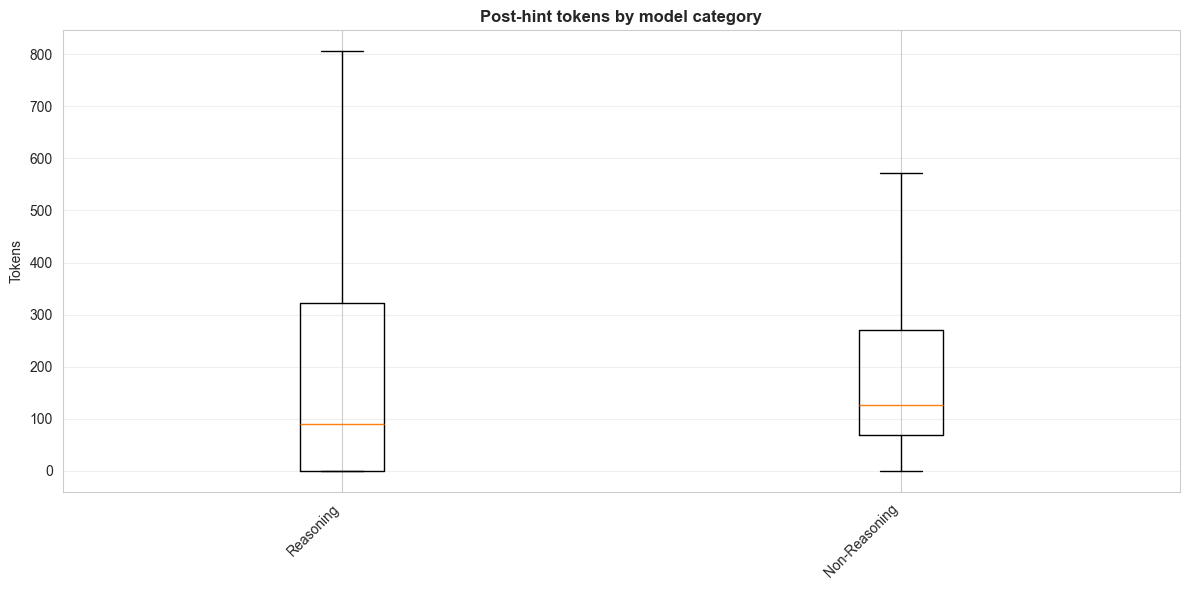

In [22]:
plot_tokens_boxplot(per_question_tokens, "hint_tokens", "model", title="Hint tokens by model")
plot_tokens_boxplot(per_question_tokens, "initial_inference_tokens", "dataset", title="Initial tokens by dataset")
plot_tokens_boxplot(per_question_tokens, "post_hint_inference_tokens", "model_category",
                    title="Post-hint tokens by model category", sort="median")


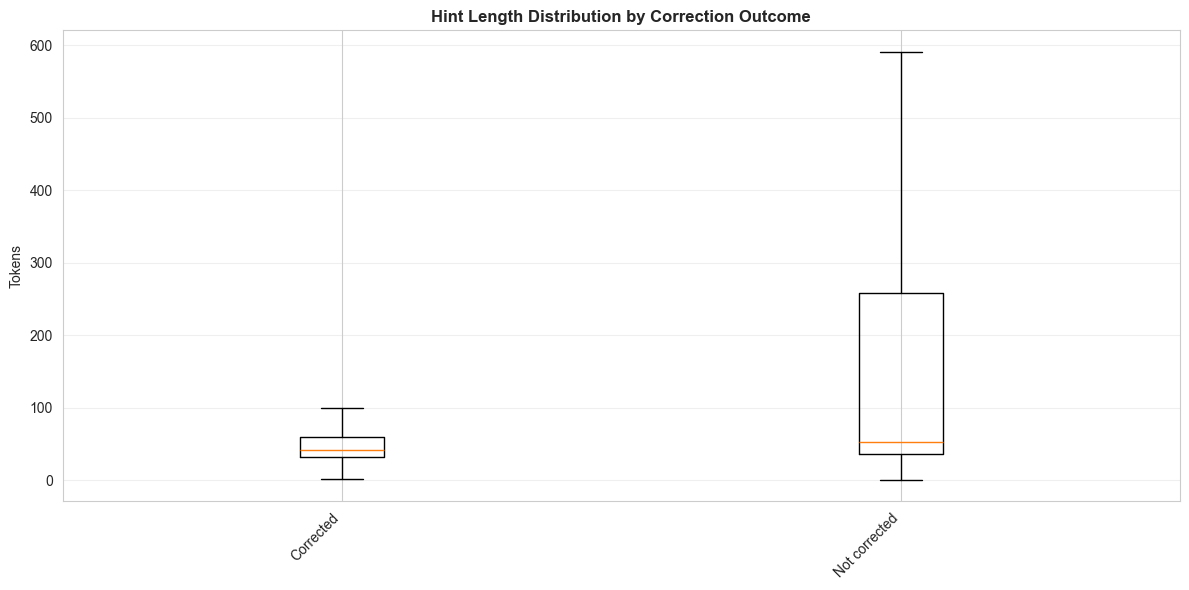

In [23]:
plot_tokens_boxplot(per_question_tokens, "hint_tokens", "hint_outcome", title="Hint Length Distribution by Correction Outcome")

In [24]:
aggregated_hint_outcomes = (
    per_question_tokens
    .groupby(['model', 'dataset', 'model_category', 'hint_outcome'])
    .agg({
        'hint_tokens': 'mean',
        'initial_inference_tokens': 'mean',
        'post_hint_inference_tokens': 'mean',

    })
    .reset_index()
)

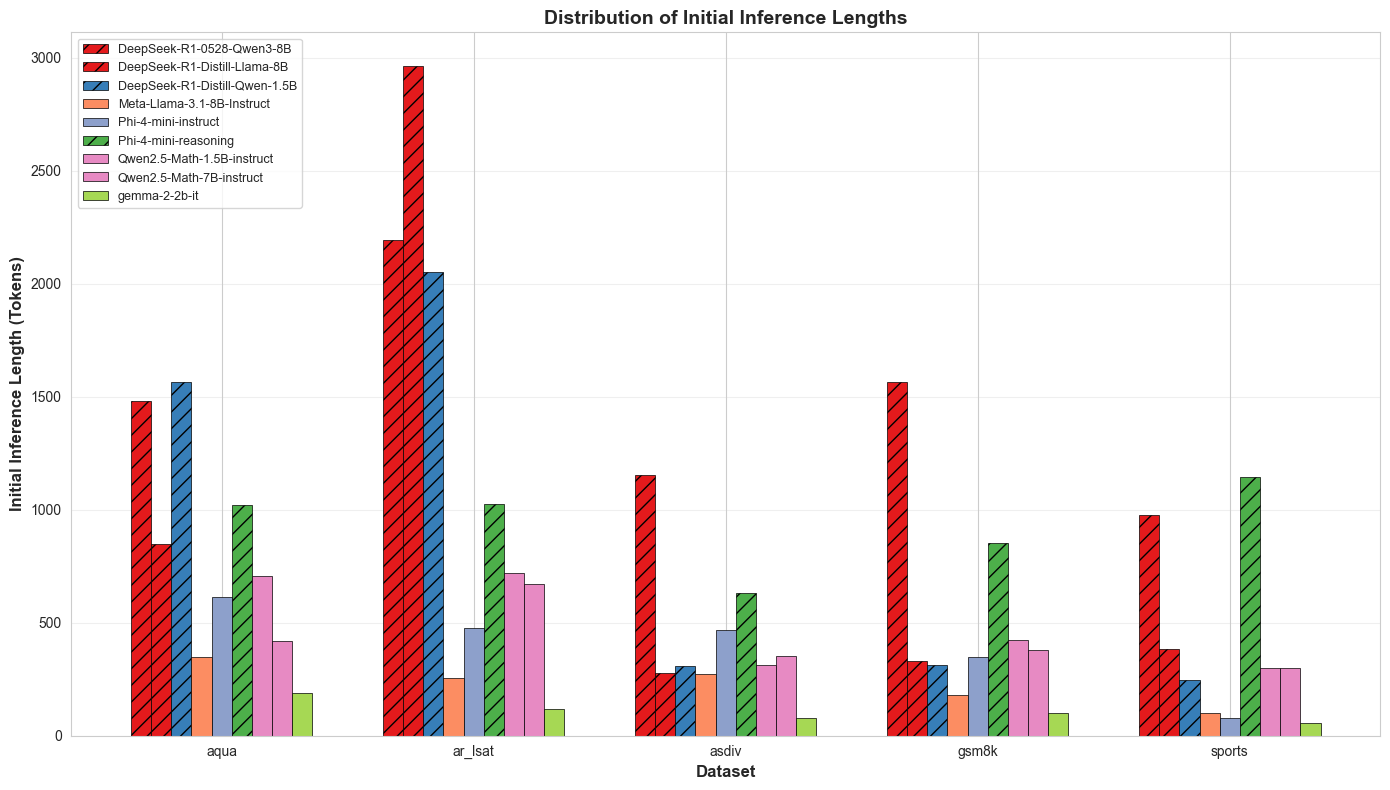

In [ ]:
plot_aggregated_metric_by_dataset(
    aggregated_hint_outcomes,
    metric_col='initial_inference_tokens',
    ylabel='Initial Inference Length (Tokens)',
    title='Initial Inference Lengths Across All Questions (Correct and Incorrect)'
)


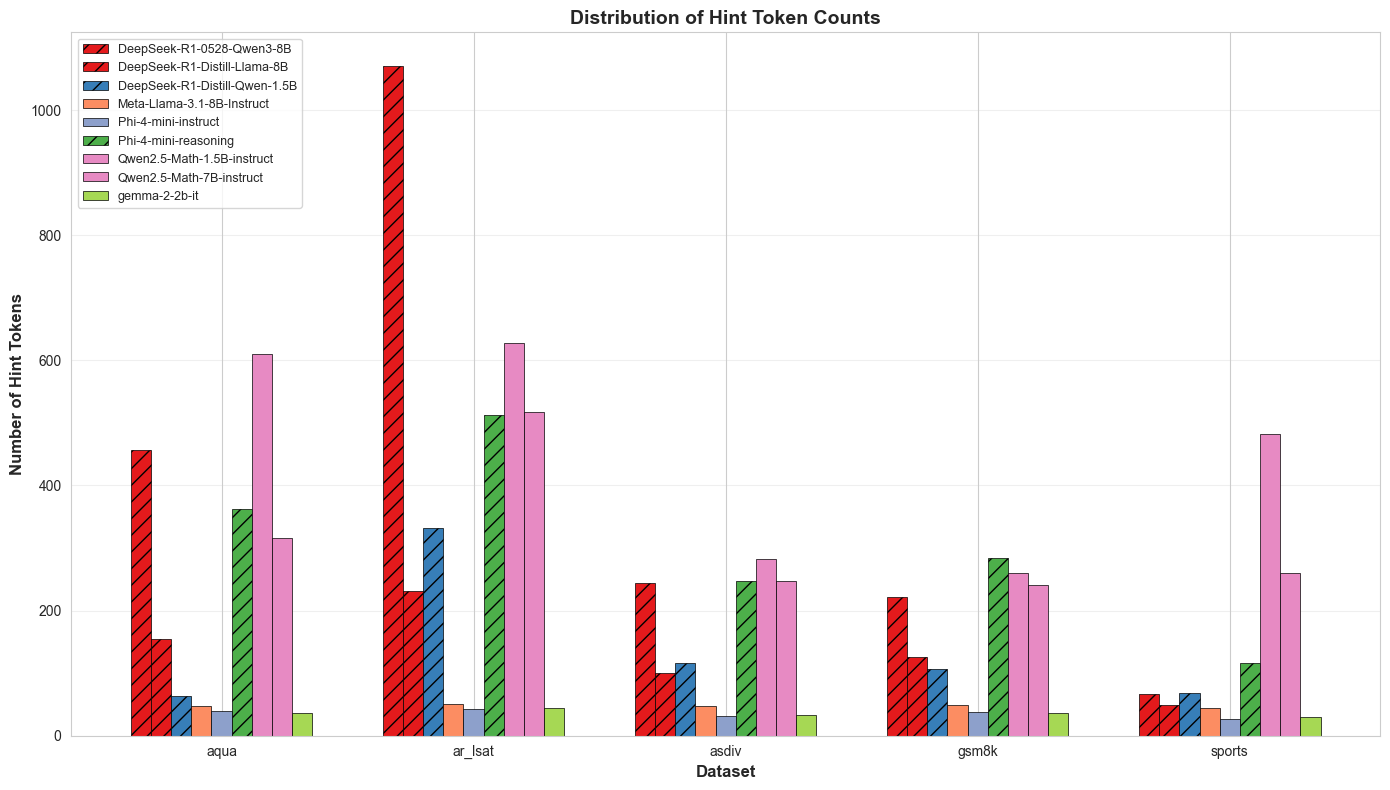

In [26]:
plot_aggregated_metric_by_dataset(
    aggregated_hint_outcomes,
    metric_col='hint_tokens',
    ylabel='Number of Hint Tokens',
    title='Distribution of Hint Token Counts'
)



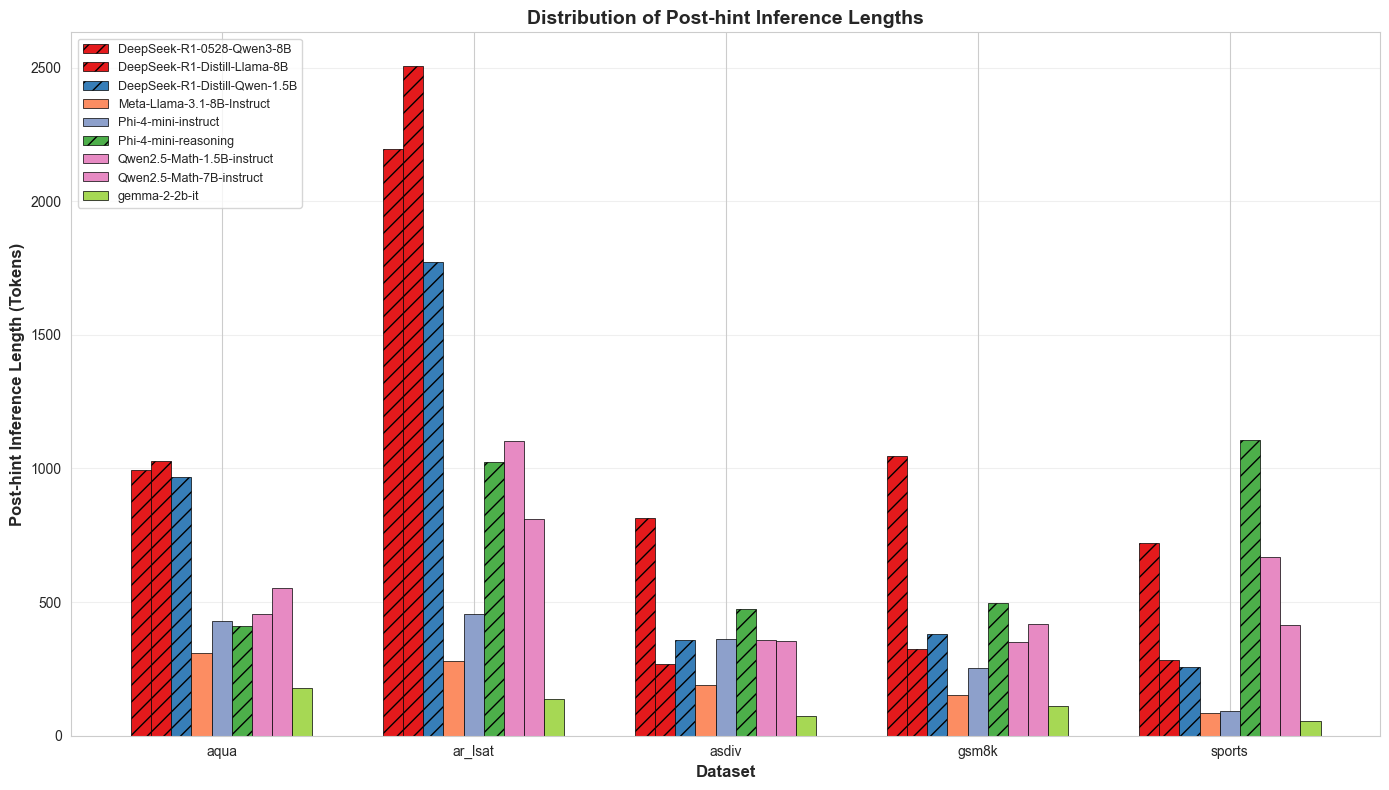

In [27]:
plot_aggregated_metric_by_dataset(
    aggregated_hint_outcomes,
    metric_col='post_hint_inference_tokens',
    ylabel='Post-hint Inference Length (Tokens)',
    title='Distribution of Post-hint Inference Lengths'
)


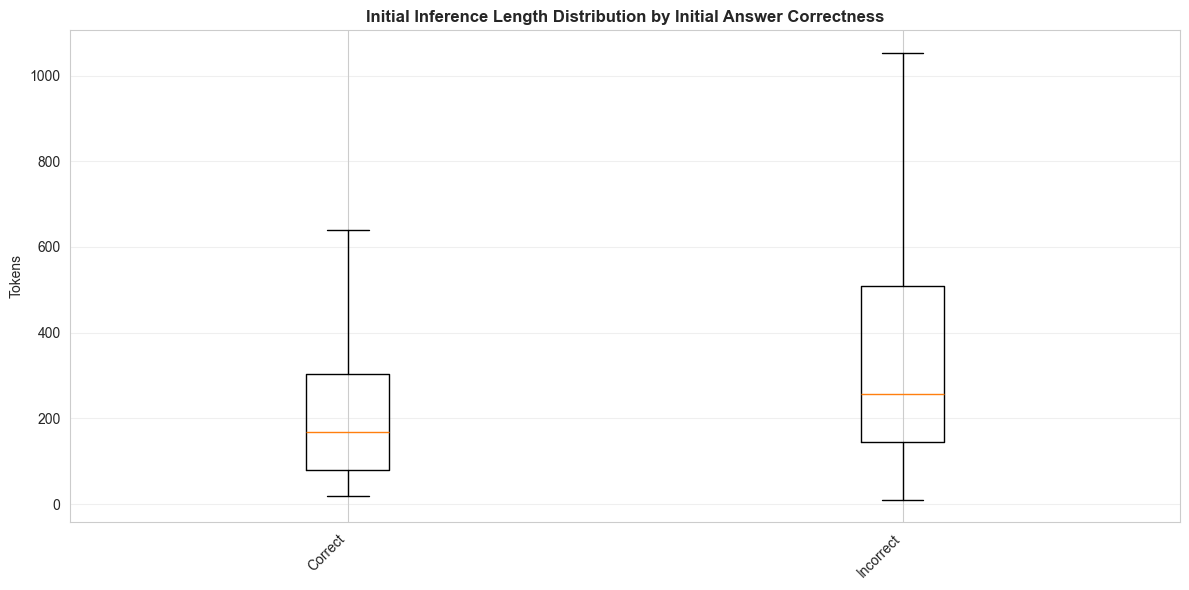

In [32]:
per_question_tokens["initial_correct_label"] = per_question_tokens["initial_correct"].map({
    0: "Incorrect",
    1: "Correct"
})

plot_tokens_boxplot(per_question_tokens, "initial_inference_tokens", "initial_correct_label", title="Initial Inference Length Distribution by Initial Answer Correctness"
)